# Loading stock prices with vnstock

In [1]:
from vnstock import Quote
import pandas as pd

# Define the symbols you want to fetch data for
symbols = ['REE', 'FMC', 'DHC']
print(f"Fetching historical price data for: {symbols}")

# Dictionary to store historical data for each symbol
all_historical_data = {}

# Set date range
start_date = '2024-01-01'
end_date = '2025-03-19'
interval = '1D'

# Fetch historical data for each symbol
for symbol in symbols:
    try:
        print(f"\nProcessing {symbol}...")
        quote = Quote(symbol=symbol)
        
        # Fetch historical price data
        historical_data = quote.history(
            start=start_date,
            end=end_date,
            interval=interval,
            to_df=True
        )
        
        if not historical_data.empty:
            all_historical_data[symbol] = historical_data
            print(f"Successfully fetched {len(historical_data)} records for {symbol}")
        else:
            print(f"No historical data available for {symbol}")
    except Exception as e:
        print(f"Error fetching data for {symbol}: {e}")

# Export all historical data to a single CSV file
if all_historical_data:
    # Create a combined DataFrame with all data
    combined_data = pd.DataFrame()
    
    for symbol, data in all_historical_data.items():
        if not data.empty:
            # Make a copy of the data and rename columns to include symbol
            temp_df = data.copy()
            # Keep 'time' column as is for merging
            for col in temp_df.columns:
                if col != 'time':
                    temp_df.rename(columns={col: f'{symbol}_{col}'}, inplace=True)
            
            if combined_data.empty:
                combined_data = temp_df
            else:
                combined_data = pd.merge(combined_data, temp_df, on='time', how='outer')
    
    # Sort by time
    if not combined_data.empty:
        combined_data = combined_data.sort_values('time')
        
        # Display sample of combined data
        print("\nSample of combined data:")
        print(combined_data.head(3))
        
        # Export combined data to CSV
        combined_csv_filename = 'all_historical_data.csv'
        combined_data.to_csv(combined_csv_filename, index=False, encoding='utf-8-sig')
        print(f"\nAll historical data exported to {combined_csv_filename}")
    
    # Also create a combined DataFrame for close prices only (for comparison purposes)
    combined_prices = pd.DataFrame()
    
    for symbol, data in all_historical_data.items():
        if not data.empty:
            # Extract time and close price
            temp_df = data[['time', 'close']].copy()
            temp_df.rename(columns={'close': f'{symbol}_close'}, inplace=True)
            
            if combined_prices.empty:
                combined_prices = temp_df
            else:
                combined_prices = pd.merge(combined_prices, temp_df, on='time', how='outer')
    
    # Sort by time
    if not combined_prices.empty:
        combined_prices = combined_prices.sort_values('time')
        
        # Export combined close prices to CSV
        combined_close_csv_filename = 'combined_close_prices.csv'
        combined_prices.to_csv(combined_close_csv_filename, index=False, encoding='utf-8-sig')
        print(f"Combined close price data exported to {combined_close_csv_filename}")
else:
    print("No historical data was fetched for any symbol.")

Phiên bản Vnstock 3.2.4 đã có mặt, vui lòng cập nhật với câu lệnh : `pip install vnstock --upgrade`.
Lịch sử phiên bản: https://vnstocks.com/docs/tai-lieu/lich-su-phien-ban
Phiên bản hiện tại 3.2.2

Fetching historical price data for: ['REE', 'FMC', 'DHC']

Processing REE...
Successfully fetched 300 records for REE

Processing FMC...
Successfully fetched 300 records for FMC

Processing DHC...
Successfully fetched 300 records for DHC

Sample of combined data:
        time  REE_open  REE_high  REE_low  REE_close  REE_volume  FMC_open  \
0 2024-01-02     48.54     49.21    48.20      48.54      779590     42.97   
1 2024-01-03     48.54     48.79    48.20      48.62      376152     43.54   
2 2024-01-04     48.88     49.64    48.54      48.71      899128     43.88   

   FMC_high  FMC_low  FMC_close  FMC_volume  DHC_open  DHC_high  DHC_low  \
0     44.17    42.97      43.78       18200     36.32     36.46    35.94   
1     43.88    43.50      43.69       26222     36.08     36.41    36.08   
2     44.07    43.64      43.83       19700     36.36     37.50    36.32   

   DHC_close  DHC_volume  
0      36.08      118392  
1      36.36      163177  
2      37.08      319156  

All histo

In [2]:
#print(combined_prices.head())
#print(combined_data.head())

In [3]:
# Set the time column as index and ensure it's datetime format
combined_prices_indexed = combined_prices.copy()
combined_prices_indexed['time'] = pd.to_datetime(combined_prices_indexed['time'])
combined_prices_indexed.set_index('time', inplace=True)

# Calculate daily returns for each stock
returns_df = pd.DataFrame(index=combined_prices_indexed.index)
for symbol in symbols:
    column_name = f'{symbol}_close'
    returns_df[symbol] = combined_prices_indexed[column_name].pct_change()

# Drop the first row which will have NaN values due to pct_change()
returns_df = returns_df.dropna()
# Create an equal-weighted portfolio
portfolio_returns = returns_df.mean(axis=1)


# Loading VNINDEX for benchmarking

In [4]:
from vnstock import Vnstock
symbol='VCI'
source='VCI'
stock = Vnstock().stock(symbol=symbol, source=source)
stock.trading.price_board(['VNINDEX'])
vnindex_data=stock.quote.history(start=start_date, end=end_date)
print(vnindex_data.head())

        time   open   high    low  close   volume
0 2024-01-02  32.55  32.55  31.83  32.02  7175876
1 2024-01-03  31.94  32.32  31.64  32.32  3332592
2 2024-01-04  32.40  33.04  32.13  32.13  9110211
3 2024-01-05  32.25  32.32  31.91  32.17  3825239
4 2024-01-08  32.36  32.78  32.28  32.32  4107758


In [5]:
# Process VNINDEX data
vnindex_data['time'] = pd.to_datetime(vnindex_data['time'])
vnindex_data.set_index('time', inplace=True)
vnindex_data.sort_index(inplace=True)
    
# Calculate VNINDEX returns
benchmark_rets = vnindex_data['close'].pct_change().dropna()
    
# Align benchmark returns with portfolio returns (same dates)
benchmark_rets = benchmark_rets.reindex(portfolio_returns.index)
benchmark_rets = benchmark_rets.fillna(method='ffill')  # Forward fill any missing dates

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.


In [6]:
print(benchmark_rets.head())

time
2024-01-03    0.009369
2024-01-04   -0.005879
2024-01-05    0.001245
2024-01-08    0.004663
2024-01-09    0.000000
Name: close, dtype: float64


In [7]:
# 1. Make a copy of the combined_prices DataFrame
prices_df = combined_prices.copy()

# 2. Convert the 'time' column to datetime if it's not already
prices_df['time'] = pd.to_datetime(prices_df['time'])

# 3. Set the 'time' column as the index
prices_df.set_index('time', inplace=True)

# 4. Extract only the close price columns and rename them to just the symbol names
close_price_columns = [col for col in prices_df.columns if '_close' in col]
prices_df = prices_df[close_price_columns]
prices_df.columns = [col.replace('_close', '') for col in close_price_columns]

# 5. Make sure there are no NaN values
prices_df = prices_df.dropna()
print(prices_df.head())

              REE    FMC    DHC
time                           
2024-01-02  48.54  43.78  36.08
2024-01-03  48.62  43.69  36.36
2024-01-04  48.71  43.83  37.08
2024-01-05  48.45  43.88  37.98
2024-01-08  47.95  43.88  39.50


In [8]:
risk_free_rate=0.02
risk_aversion=1

In [9]:
from pypfopt.expected_returns import returns_from_prices
log_returns=False
returns = returns_from_prices(prices_df, log_returns=log_returns)
returns.head()

,REE,FMC,DHC
time,,,
2024-01-03,0.001648,-0.002056,0.007761
2024-01-04,0.001851,0.003204,0.019802
2024-01-05,-0.005338,0.001141,0.024272
2024-01-08,-0.010320,0.000000,0.040021
2024-01-09,-0.012304,0.013218,-0.004810


# Portfolio Optimization (Mean-Variance, Min-volatilty, Max Utility)

## Setting up returns and covariance variables

In [ ]:
from pypfopt import EfficientFrontier, risk_models, expected_returns, DiscreteAllocation
from pypfopt.exceptions import OptimizationError
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import sample_cov #for covariance matrix, get more methods from risk_models
from pypfopt.efficient_frontier import EfficientFrontier


mu=mean_historical_return(prices_df, log_returns=log_returns ) #Optional: add log_returns=True
"""
For most portfolio optimization purposes, the default simple returns pct_change() are adequate, 
but logarithmic returns can provide more robust results in some cases, 
especially when dealing with volatile assets or longer time horizons.
"""
S=sample_cov(prices_df)

### Optional 

In [ ]:
"""
from pypfopt.risk_models import CovarianceShrinkage

# Assume 'prices' is a pandas DataFrame of historical asset prices
S = CovarianceShrinkage(prices_df).ledoit_wolf()
"""

"\nfrom pypfopt.risk_models import CovarianceShrinkage\n\n# Assume 'prices' is a pandas DataFrame of historical asset prices\nS = CovarianceShrinkage(prices_df).ledoit_wolf()\n"

## Create an instance of Efficient Frontier

In [11]:
#Createa an instance 
ef=EfficientFrontier(mu,S,weight_bounds=(0, 1)) # Adding weight_bounds is optional, for clarifying short positions, 0 and 1 means weights will be positive

## Generate the EF with simulated portfolios and 3 optimized portfolios

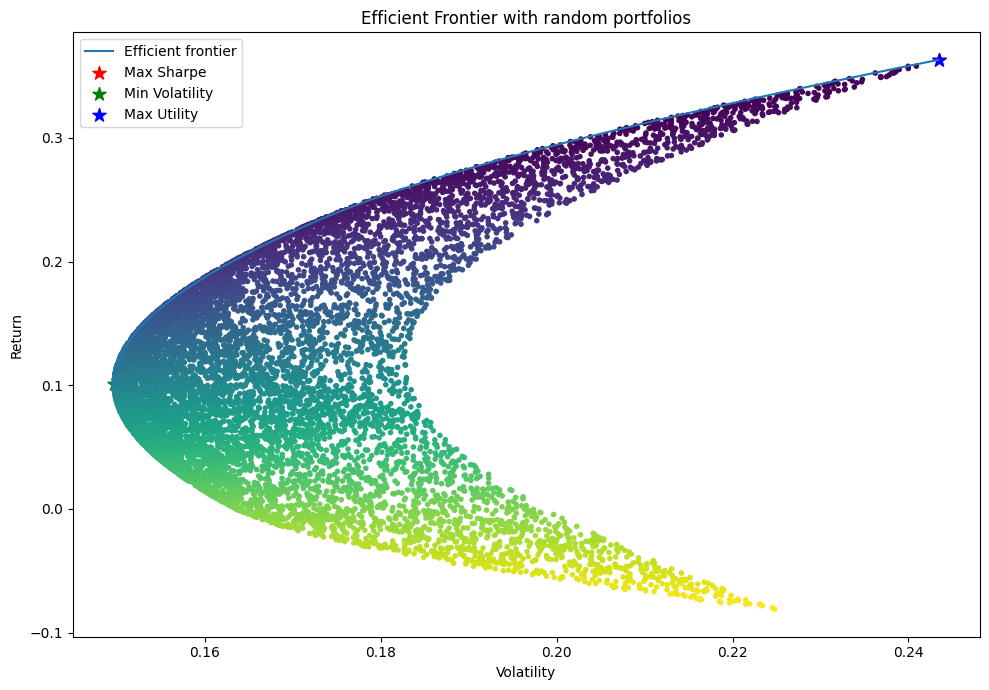

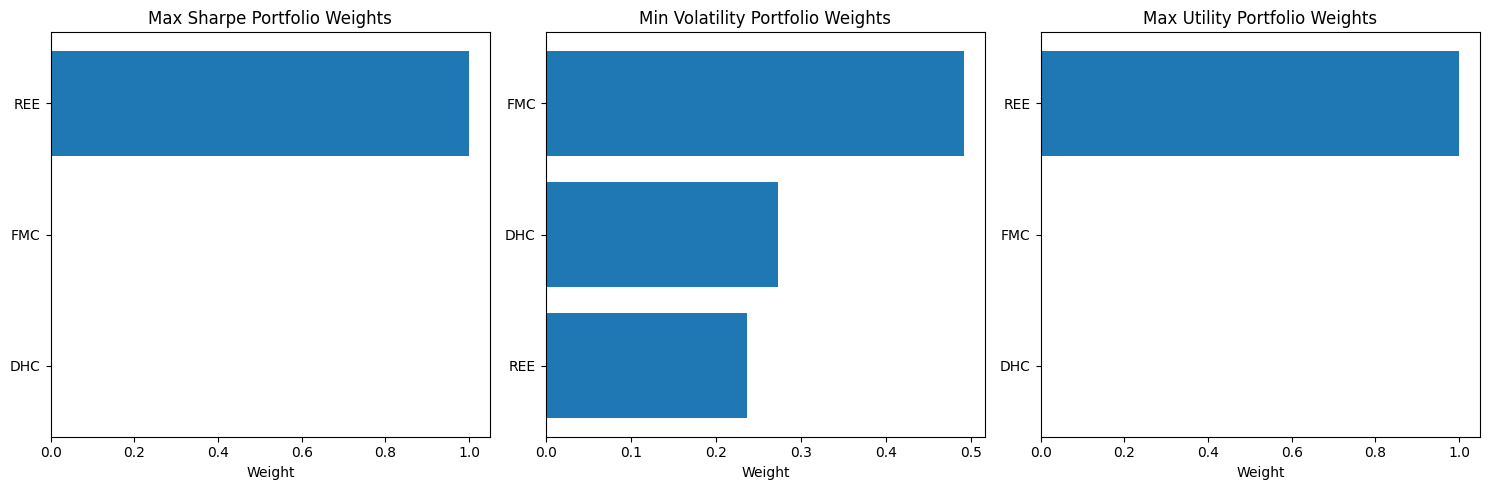

Maximum Sharpe Portfolio:
Expected annual return: 0.3631
Annual volatility: 0.2435
Sharpe Ratio: 1.4093

Minimum Volatility Portfolio:
Expected annual return: 0.1008
Annual volatility: 0.1497
Sharpe Ratio: 0.5397

Maximum Utility Portfolio:
Expected annual return: 0.3631
Annual volatility: 0.2435
Sharpe Ratio: 1.4093
Risk Aversion Parameter: 1


In [12]:
import matplotlib.pyplot as plt
from pypfopt import plotting
import numpy as np
# Create the plot
fig, ax = plt.subplots(figsize=(10, 7))

# Create a new instance for plotting the efficient frontier
ef_plot = EfficientFrontier(mu, S)
plotting.plot_efficient_frontier(ef_plot, ax=ax, show_assets=False)

# Create a separate instance for max Sharpe ratio portfolio
ef_max_sharpe = EfficientFrontier(mu, S)
ef_max_sharpe.max_sharpe(risk_free_rate=risk_free_rate)
weights_max_sharpe = ef_max_sharpe.clean_weights()
ret_tangent, std_tangent, sharpe = ef_max_sharpe.portfolio_performance(risk_free_rate=risk_free_rate)

# Create another separate instance for min volatility portfolio
ef_min_vol = EfficientFrontier(mu, S)
ef_min_vol.min_volatility()
weights_min_vol = ef_min_vol.clean_weights()
ret_min_vol, std_min_vol, sharpe_min_vol = ef_min_vol.portfolio_performance(risk_free_rate=risk_free_rate)

# Create another separate instance for max utility portfolio
ef_max_utility = EfficientFrontier(mu, S)
ef_max_utility.max_quadratic_utility(risk_aversion=risk_aversion, market_neutral=False)
weights_max_utility = ef_max_utility.clean_weights()
ret_utility, std_utility, sharpe_utility = ef_max_utility.portfolio_performance(risk_free_rate=risk_free_rate)

# Plot the tangency portfolio (max Sharpe)
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")

# Plot the minimum volatility portfolio
ax.scatter(std_min_vol, ret_min_vol, marker="*", s=100, c="g", label="Min Volatility")

# Plot the maximum utility portfolio
ax.scatter(std_utility, ret_utility, marker="*", s=100, c="b", label="Max Utility")

# Generate random portfolios
n_samples = 10000
w = np.random.dirichlet(np.ones(ef_plot.n_assets), n_samples)
rets = w.dot(ef_plot.expected_returns)
stds = np.sqrt(np.diag(w @ ef_plot.cov_matrix @ w.T))
sharpes = rets / stds
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

# Output
ax.set_title("Efficient Frontier with random portfolios")
ax.legend()
plt.tight_layout()
plt.savefig("ef_scatter.png", dpi=200)
plt.show()

# In a separate cell, plot the weights for all three portfolios
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plotting.plot_weights(weights_max_sharpe)
plt.title("Max Sharpe Portfolio Weights")

plt.subplot(1, 3, 2)
plotting.plot_weights(weights_min_vol)
plt.title("Min Volatility Portfolio Weights")

plt.subplot(1, 3, 3)
plotting.plot_weights(weights_max_utility)
plt.title("Max Utility Portfolio Weights")

plt.tight_layout()
plt.show()

# Print the performance metrics for comparison
print("Maximum Sharpe Portfolio:")
print(f"Expected annual return: {ret_tangent:.4f}")
print(f"Annual volatility: {std_tangent:.4f}")
print(f"Sharpe Ratio: {sharpe:.4f}")

print("\nMinimum Volatility Portfolio:")
print(f"Expected annual return: {ret_min_vol:.4f}")
print(f"Annual volatility: {std_min_vol:.4f}")
print(f"Sharpe Ratio: {sharpe_min_vol:.4f}")

print("\nMaximum Utility Portfolio:")
print(f"Expected annual return: {ret_utility:.4f}")
print(f"Annual volatility: {std_utility:.4f}")
print(f"Sharpe Ratio: {sharpe_utility:.4f}")
print(f"Risk Aversion Parameter: {risk_aversion}")

### More examples of optimization methods

In [ ]:
"""
#Optimizers, apply the optimizer of choice after instantiating EfficientFrontier(mu,S)
#Portfolio with max sharpe ratio
ef.max_sharpe(risk_free_rate=risk_free_rate)
#ef.min_volatility()
ef.portfolio_performance(risk_free_rate=risk_free_rate)

#Optimizer
#Maximise return for a target risk. The resulting portfolio will have a volatility less than the target (but not guaranteed to be equal).
target_volatility=0.15
conditional_volatility_portfolio=ef.efficient_risk(target_volatility=target_volatility,market_neutral=True)
print(conditional_volatility_portfolio)
#ef.portfolio_performance(risk_free_rate=risk_free_rate) #re-calculate portfolio performance on conditional_volatility_portfolio 

#Optimizer
#Calculate the ‘Markowitz portfolio’, minimising volatility for a given target return.
target_return=0.2
conditional_return_portfolio=ef.efficient_return(target_return=target_return, market_neutral=False) #market_neutral=False means no shorting allowed
print(conditional_return_portfolio)
ef.portfolio_performance(risk_free_rate=risk_free_rate) #re-calculate portfolio performance on conditional_return_portfolio

#Optimizer
#Maximise the given quadratic utility
max_utility_portfolio=ef.max_quadratic_utility(risk_aversion=risk_aversion, market_neutral=False)
print(max_utility_portfolio)
#ef.portfolio_performance(risk_free_rate=risk_free_rate)

"""

### List stocks by sectors and icb

In [ ]:
from vnstock import Listing
sectors=stock.listing.symbols_by_industries()
sectors

In [ ]:
#Check if a stock in the portfolio is on the list and get relavant information
sectors[sectors['symbol']== 'FMC']

In [ ]:
#Get a list of unique sectors with icb3
unique_sectors=sectors['icb_name3'].unique() #np array
pd.DataFrame(unique_sectors)

# Create a sceener with a pre-defind criteria

In [ ]:

from vnstock import Screener
from vnstock import Vnstock
# Initialize Vnstock with a symbol and source
symbol = 'VCI'  # Any valid symbol
source = 'VCI'  # Same as symbol for simplicity
stock = Vnstock().stock(symbol=symbol, source=source)
params = {
            "exchangeName": "HOSE,HNX,UPCOM",
            "marketCap": (100, 1000),
            "dividendYield": (5, 10)
        }

df_filtered = stock.screener.stock(params = params, limit=1700) #drop_lang='vi' 
df_filtered


In [ ]:
#screener_df = stock.screener.stock(params={"exchangeName": "HOSE,HNX,UPCOM"}, limit=1700)
#screener_df

# Hierarchical Risk Parity

In [ ]:
from pypfopt import HRPOpt
hrp = HRPOpt(returns=returns) #create the object
weights = hrp.optimize() #optimize the object
weights

### Round the weights and save to a json file for webview

In [ ]:
hrp.clean_weights()
#Saving weights to csv
hrp.save_weights_to_file("./outputs/hrp_weights.json")


# Dollars Allocation

In [ ]:
# This extracts the last row of prices_df and converts it to a Series

from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
latest_prices = get_latest_prices(prices_df) #Alternatives: latest_prices = prices_df.iloc[-1]
# Assuming you already have optimized weights (e.g., from max_sharpe or min_volatility)
# And a total portfolio value
portfolio_value = 100000  # 1 million VND

# You can use either the Series or dict version of latest_prices
da = DiscreteAllocation(weights, latest_prices, total_portfolio_value=portfolio_value)
allocation, leftover = da.greedy_portfolio()

### Plotting with the HRP portfolio with pypfopt

In [ ]:
from pypfopt import plotting
plotting.plot_dendrogram(hrp, ax=None, show_tickers=True)

### Plot the covariance

In [ ]:
# Plot the covariance
plotting.plot_covariance(S, plot_correlation=True, show_tickers=True)

# Riskfolio

In [13]:
import warnings
#warnings.filterwarnings("ignore")
import riskfolio as rp
"""
# Building the portfolio object
port = rp.Portfolio(returns=returns)

# Calculating optimal portfolio

# Select method and estimate input parameters:

method_mu='hist' # Method to estimate expected returns based on historical data.
method_cov='hist' # Method to estimate covariance matrix based on historical data.

port.assets_stats(method_mu=method_mu, method_cov=method_cov)
"""
# Estimate optimal portfolio:

model='Classic' # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
rm = 'MV' # Risk measure used, this time will be variance
obj = 'Sharpe' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
hist = True # Use historical scenarios for risk measures that depend on scenarios
rf = 0 # Risk free rate
l = 0 # Risk aversion factor, only useful when obj is 'Utility'

#w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)
#display(w.T)



### Plot the weights on a pie chart

In [ ]:
# Plotting the composition of the portfolio
#Convert weights_max_sharpe variable to series or use w=w to use the wieghts generated by riskfolio

ax = rp.plot_pie(w=pd.Series(weights_max_sharpe), title='Sharpe Mean Variance', others=0.05, nrow=25, cmap = "tab20",
                 height=6, width=10, ax=None)

### Setting up risk measures variables

In [15]:
# Risk Measures available:
#
# 'MV': Standard Deviation.
# 'MAD': Mean Absolute Deviation.
# 'MSV': Semi Standard Deviation.
# 'FLPM': First Lower Partial Moment (Omega Ratio).
# 'SLPM': Second Lower Partial Moment (Sortino Ratio).
# 'CVaR': Conditional Value at Risk.
# 'EVaR': Entropic Value at Risk.
# 'WR': Worst Realization (Minimax)
# 'MDD': Maximum Drawdown of uncompounded cumulative returns (Calmar Ratio).
# 'ADD': Average Drawdown of uncompounded cumulative returns.
# 'CDaR': Conditional Drawdown at Risk of uncompounded cumulative returns.
# 'EDaR': Entropic Drawdown at Risk of uncompounded cumulative returns.
# 'UCI': Ulcer Index of uncompounded cumulative returns.

rms = ['MV', 'MAD', 'MSV', 'FLPM', 'SLPM', 'CVaR',
       'EVaR', 'WR', 'MDD', 'ADD', 'CDaR', 'UCI', 'EDaR']
"""
w_s = pd.DataFrame([])

for i in rms:
    w = port.optimization(model=model, rm=i, obj=obj, rf=rf, l=l, hist=hist)
    w_s = pd.concat([w_s, w], axis=1)
    
w_s.columns = rms
"""

'\nw_s = pd.DataFrame([])\n\nfor i in rms:\n    w = port.optimization(model=model, rm=i, obj=obj, rf=rf, l=l, hist=hist)\n    w_s = pd.concat([w_s, w], axis=1)\n    \nw_s.columns = rms\n'

In [ ]:
w_s.style.format("{:.2%}").background_gradient(cmap='YlGn')

### Plot the historical compounded cummulative returns

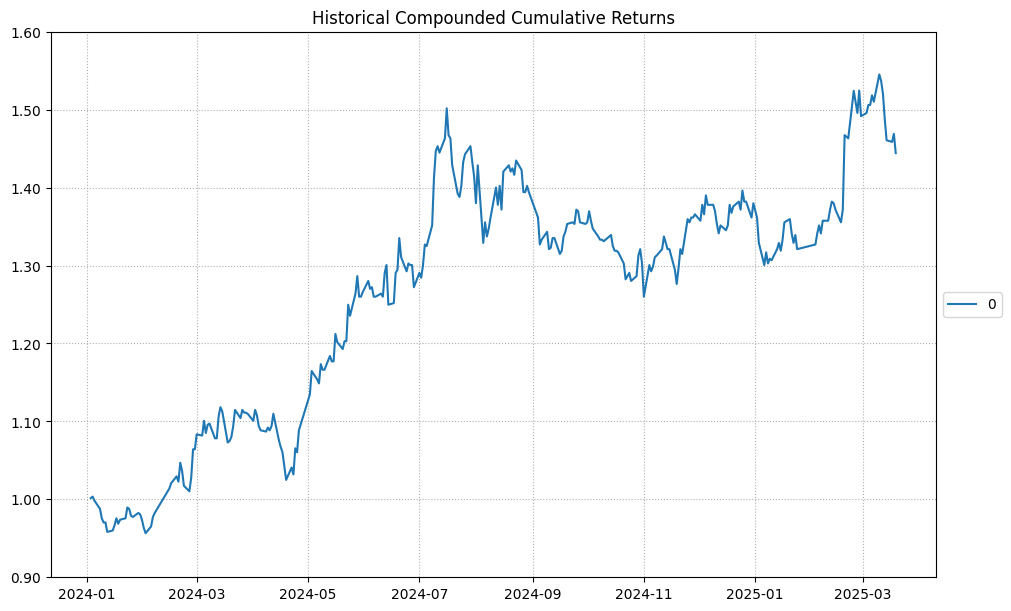

In [19]:
ax = rp.plot_series(returns=returns,
                    w=pd.Series(weights_max_sharpe),
                    cmap='tab20',
                    height=6,
                    width=10,
                    ax=None)

### Plot risk contribution on a bar chart

In [ ]:
ax = rp.plot_risk_con(w=weights_max_sharpe,
                      cov=S, #using covariance from pypfopt lib, which in this case is sample_cov
                      returns=returns,
                      rm=rm,
                      rf=risk_free_rate,
                      alpha=0.05,
                      color="tab:blue",
                      height=6,
                      width=10,
                      t_factor=252,
                      ax=None)

### Plot a histogram of returns distribution

In [ ]:
ax = rp.plot_hist(returns=returns,
                  w=pd.Series(weights_max_sharpe),
                  alpha=0.05,
                  bins=50,
                  height=6,
                  width=10,
                  ax=None)

In [ ]:
ax = rp.plot_range(returns=returns,
                   w=pd.Series(weights_max_sharpe),
                   alpha=0.05,
                   a_sim=100,
                   beta=None,
                   b_sim=None,
                   bins=50,
                   height=6,
                   width=10,
                   ax=None)

In [ ]:
"""
ax = rp.jupyter_report(returns,
                       w,
                       rm='MV',
                       rf=0,
                       alpha=0.05,
                       height=6,
                       width=14,
                       others=0.05,
                       nrow=25)
"""                       

### Plot the full report

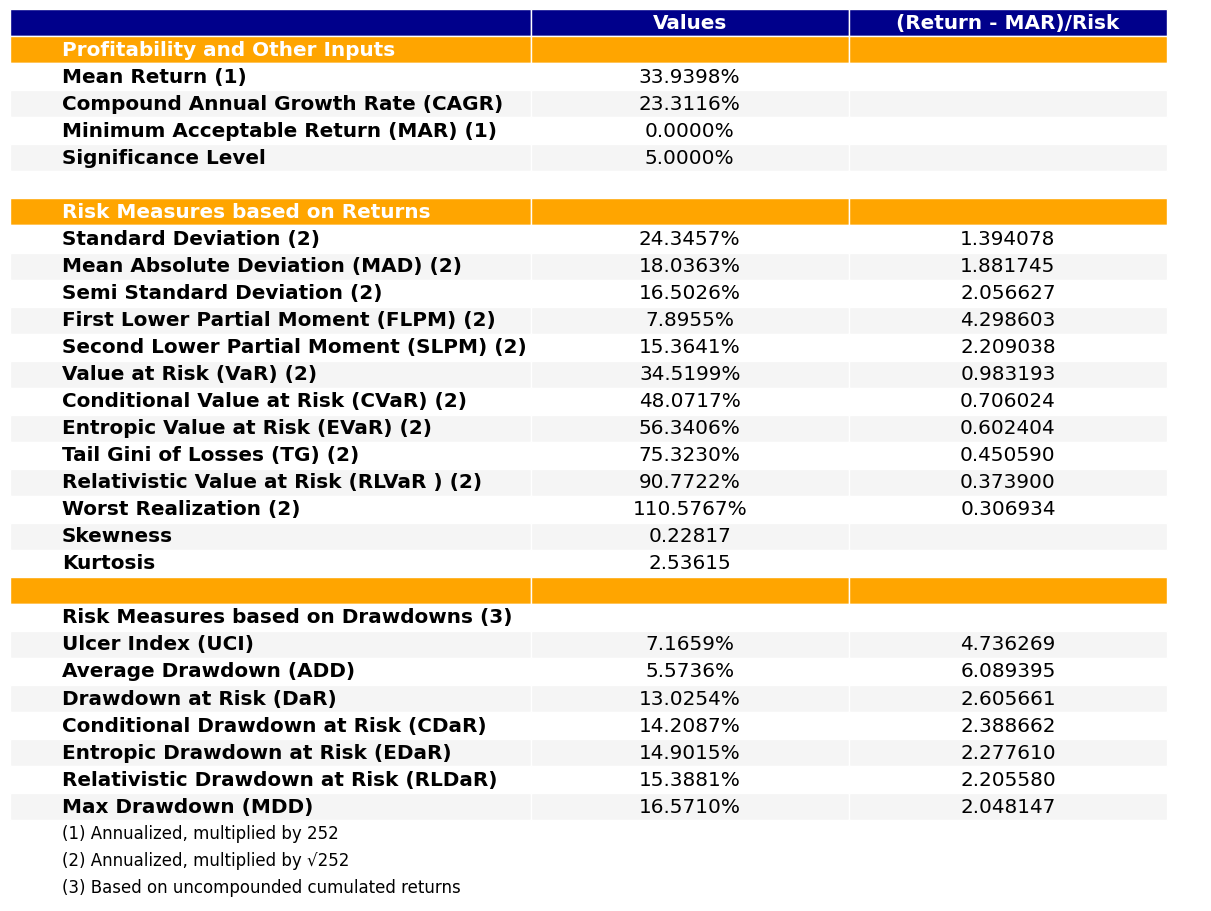

In [20]:
ax = rp.plot_table(returns=returns,
                   w=pd.Series(weights_max_sharpe),
                   MAR=0,
                   alpha=0.05,
                   ax=None)

### Save a report to excel

In [ ]:
rp.excel_report(returns,
                w,
                rf=risk_free-rate, # could =0 or =risk_free-rate
                alpha=0.05,
                t_factor=252,
                ini_days=1,
                days_per_year=252,
                name="./outputs/report")

In [ ]:
ax = rp.plot_factor_risk_con(w=pd.Series(weights_max_sharpe),
                             cov=S,
                             returns=returns,
                             factors=returns,
                             B=None,
                             const=True,
                             rm=rm,
                             rf=0,
                             feature_selection="PCR", #Indicate the method used to estimate the loadings matrix, PCR or stepwise
                             n_components=0.95,
                             height=6,
                             width=10,
                             t_factor=252,
                             ax=None)

In [ ]:
ax = rp.plot_drawdown(returns=returns,
                      w=pd.Series(weights_max_sharpe), # or w=w
                      alpha=0.05,
                      height=8,
                      width=10,
                      ax=None)

# Quantstats

In [ ]:
import quantstats as qs
qs.extend_pandas()

In [ ]:
#View a complete list of available metrics
[f for f in dir(qs.stats) if f[0] != '_'] 

In [ ]:
qs.stats.avg_loss(portfolio_returns)

In [ ]:
#View a complete list of available plots, some will not work in pandas 3.0 
[f for f in dir(qs.plots) if f[0] != '_']

In [ ]:
qs.plots.rolling_beta(portfolio_returns,benchmark_rets) #benchmark_rets should have been index fund rather than VNINDEX

# Constraints Portfolio

In [ ]:
import pandas as pd

# Function to create a sector mapping dictionary from the grouped sectors
def create_sector_mapper(grouped_data):
    sector_mapper = {}
    
    for sector_name, group_df in grouped_data:
        # For each stock in this sector group, add to the dictionary
        for _, row in group_df.iterrows():
            sector_mapper[row['symbol']] = sector_name
    
    return sector_mapper

# Group by sector
grouped = sectors.groupby('icb_name3')

# Create the sector mapper dictionary
sector_mapper = create_sector_mapper(grouped)

print(f"Created sector mapper for {len(sector_mapper)} symbols")

In [ ]:
#sector_mapper

In [ ]:
sector_lower = {"Sản xuất & Phân phối Điện": 0.1, "Sản xuất thực phẩm": 0.05}  # Min percentages
sector_upper = {"Sản xuất & Phân phối Điện": 0.4, "Sản xuất thực phẩm/Gas": 0.2}      # Max percentages

In [ ]:
import json
import os
output_dir = "./outputs"
# Save the sector mapper to a JSON file in the specified directory
output_path = os.path.join(output_dir, "sector_map.json")
with open(output_path, 'w',encoding='utf-8') as json_file:
    json.dump(sector_mapper, json_file, indent=4, ensure_ascii=False) #ensure_ascii=False and encoding='utf-8' for Vietnamese language encoding

In [ ]:
from pypfopt import EfficientFrontier
#Instantiate an instance  
constraint_portfolio = EfficientFrontier(mu, S)

# Apply sector constraints
constraint_portfolio.add_sector_constraints(sector_mapper, sector_lower, sector_upper)




In [ ]:
# Optimize the portfolio
constraint_portfolio_weights = constraint_portfolio.max_sharpe(risk_free_rate=risk_free_rate)
constraint_portfolio_weights

In [ ]:
import os
# Convert the dictionary to a DataFrame for CSV export
sector_df = pd.DataFrame(list(sector_mapper.items()), columns=['symbol', 'sector'])

# Ensure the output directory exists
output_dir = "./outputs"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Save the DataFrame to a CSV file with UTF-8 encoding
output_path = os.path.join(output_dir, "sector_map.csv")
sector_df.to_csv(output_path, index=False, encoding='utf-8-sig')

print(f"Sector mapper saved to '{output_path}' with UTF-8 encoding")

# Tradingview

In [ ]:

#!pip install --upgrade --no-cache-dir git+https://github.com/rongardF/tvdatafeed.git
#https://github.com/rongardF/tvdatafeed?tab=readme-ov-file

from tvDatafeed import TvDatafeed, Interval
import tvDatafeed
import datetime
#Getting stock data using nologin method
tv = TvDatafeed()

data = tv.get_hist('REE','HOSE', Interval.in_monthly,n_bars=120)


In [ ]:
#data

In [ ]:
"""
from tvDatafeed import TvDatafeed,Interval

username = 'YourTradingViewUsername'
password = 'YourTradingViewPassword'
    
tv=TvDatafeed(username, password, chromedriver_path=None)

"""